In [1]:
from factor_estimator import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from asset_allocation import AssetAllocation
from IPython.display import display
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

Factor investing is one of the most interesting approaches to "outperform the market" if the market is a usual market cap weighted portfolio (like MSCI World, MSCI ACWI, FTSE All World or to a degree a S&P500).
When diving into the literature one finds a whole host of factors which may be valuable. The most intersting ones come from Fama and French (Size (SmB), Value (HmL), Conservative (CvA) and Robustness (RmW). There are more out there like Momentum (Carhart, 1997) or Liquidity (Pástor, Stambaugh 2003).
Since the author of this analysis is based out of Germany, the amount of different investment options is limited. Thus we keep with the following selection, where the number represents the MSCI Index code:

In [2]:
index_codes = get_common_index_codes()
index_codes.pop("Small-Cap")
index_codes.pop("High-Dividend (World)")
display(pd.DataFrame.from_dict(index_codes))


,MSCI World,Value,Quality,Multi-Factor,Momentum,Low Volatility (World),Small-Cap (Value)
ISIN,IE00BJ0KDQ92,IE00BL25JM42,IE00BL25JL35,IE00BZ0PKT83,IE00BL25JP72,IE00BL25JN58,IE00BSPLC413
code,990100,705130,702787,706536,703755,129896,139249
region,Developed,Developed,Developed,Developed,Developed,Developed,US
ticker,NaN,NaN,NaN,NaN,NaN,NaN,zprv-gy
vendor,Xtrackers,Xtrackers,Xtrackers,iShares,Xtrackers,Xtrackers,SPDR


The question asked in this analysis is: **How do I mix the ETFs for the indecies** above?

In general there are two approaches for factor investing. The integrated approach uses one etf where the stocks are picked to satisfy more then one factor at a time. Those ETFs are a one-stop solution, but have significantly higher costs. Also there is currently only a very limited selection available in Germany. The most important one is [iShares Edge MSCI World Multifactor](https://www.justetf.com/de-en/etf-profile.html?isin=IE00BZ0PKT83) which is based on the WORLD DIVERSIFIED MULTI-FACTOR index.
The TER for this is 0.5% and thus its ~0.35% higher than a market neutral MSCI World and ~0.25% higher than most 'single factor ETF'

The other approach is a *index of indicies* where you mix different ETFs to target more than a single factor. The reasoning behind that is, that factors are not stable over time and it is desireable to target more than one for continuity.

In this analysis we will try to estimate the 5 factors of the Fama French 5-Factor model. Those are MKT, SMB, HML, CWA and RMW. We then try to find the most suitable combination of ETFs for our purposes.

Let's get the data first. The data is directly taking from MSCI, and is thus available for a longer range. We examine data from 1998-2020, since this is the time span with daily data available. Every point is always normalized to the 01/01/1997, so we can look at it like we invested a euro back then.

In [3]:
data = []
start_date="19981130"
#start_date="20080101"
for key in index_codes.keys():
    code = index_codes[key]["code"]
    d = get_historic_stock_data(code,start_date=start_date)
    d.rename(columns={"level_eod":key}, inplace=True)
    d.set_index("date")
    data.append(d)
df = data[0]
for i in range(1,len(data)):
    df = df.merge(data[i], how='left')
    
#df = pd.concat(data).groupby(level=0).first()
#df['date'] = df["date"].values.astype(float)
df.set_index("date")
print(df.columns)

Index(['date', 'MSCI World', 'Value', 'Quality', 'Multi-Factor', 'Momentum',
       'Low Volatility (World)', 'Small-Cap (Value)'],
      dtype='object')


To check the data and to understand, let's chart the data:

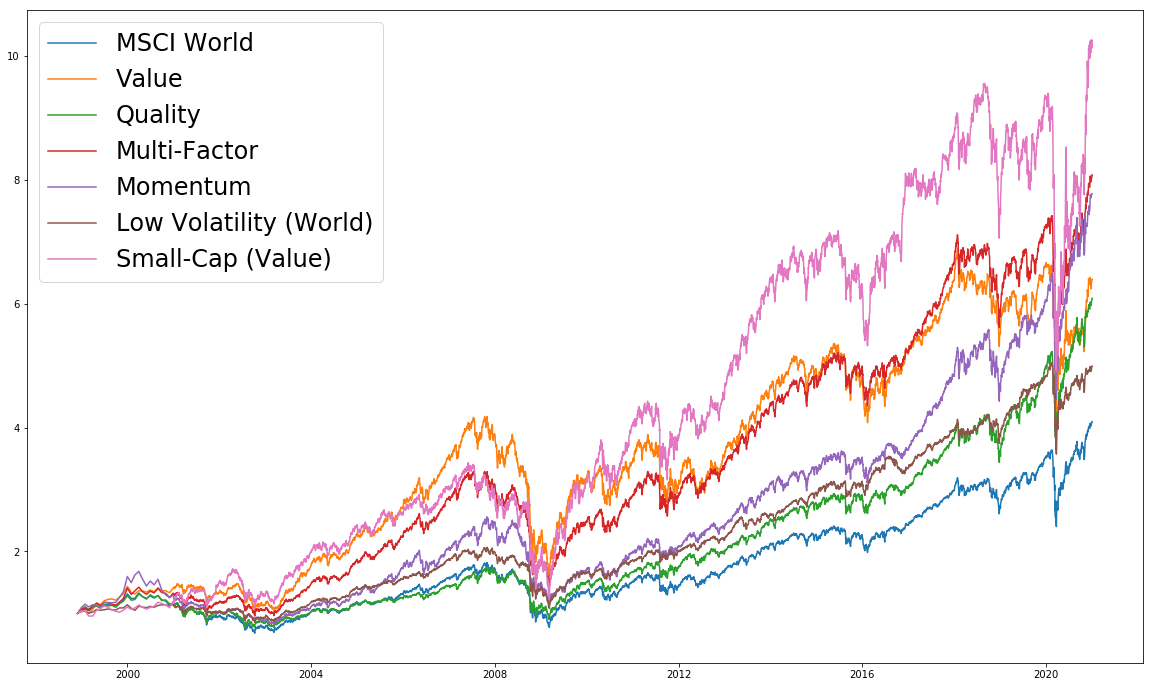

In [4]:
plt.figure(figsize=(20, 12))
for k in index_codes.keys():
    plt.plot(df["date"],df[k], label=k)
#gfg = sns.lineplot(data = df[c])
plt.legend(prop={'size':24})
plt.show()

We can see that all factors outperform the MSCI World.
We can also see that the two best running factors are Momentum and Small-Cap (Value).

Lets now calculate the factors for each of our indicies. The idea is, that the change of market price w.r.t to the risk free return can be descriped as 
\begin{equation}
    r_f = a \cdot MKT+b \cdot SMB +c \cdot HML+d \cdot RMW+e \cdot CMA
\end{equation}
The original Fama French paper knew a,b,c,d and e for a given portfolio (those are metrics like P/E), and deterimed the influence factors.
We do it the other way around. We know the influence factors from the paper and want to determine the 'sizeness' of an index (so we determine a,b,c,d,e).

In [5]:
factors = {}
fit_results = {}
for key in index_codes.keys():
    code = index_codes[key]["code"]
    print("calculating for ",code)
    fitted_factors, results, data = estimate(code,start_date=start_date,region=index_codes[key]["region"])
    factors[key] = fitted_factors
    fit_results[key] = results

calculating for  990100
calculating for  705130
calculating for  702787
calculating for  706536
calculating for  703755
calculating for  129896
calculating for  139249


Before we move forward, lets have a look at the quality of the fit:

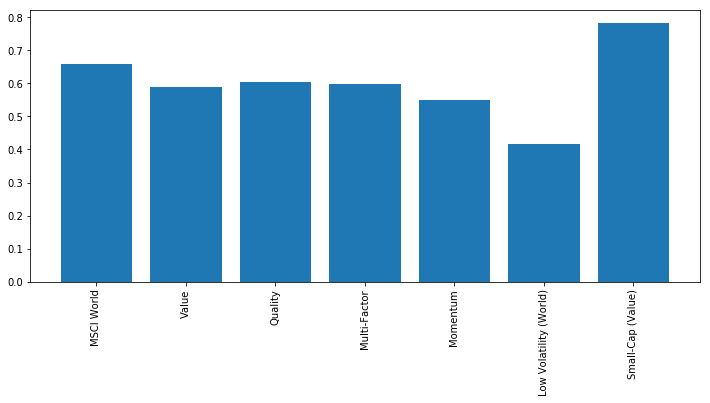

In [6]:
D={}
plt.figure(figsize=(12, 5))
for key in factors.keys():
    D[key] = fit_results[key].rsquared
plt.bar(*zip(*D.items()))
plt.xticks(rotation = 90)

plt.show()


From my perspective the r-squared value is relativily low.. The values of 0.4 are rather weak and maybe we should run further analysis here?
The original paper also quotes relativly low r² values. Maybe that's just normal?

We can also have a quick look at the global factorness of each index. Factorness is defined as
\begin{equation}
\phi = \sum_i f_i
\end{equation}
where $f_i$ is the individual factor. The key question of this analysis is if $\phi$ is the factor to optimize on or how to weight the individual contributions.

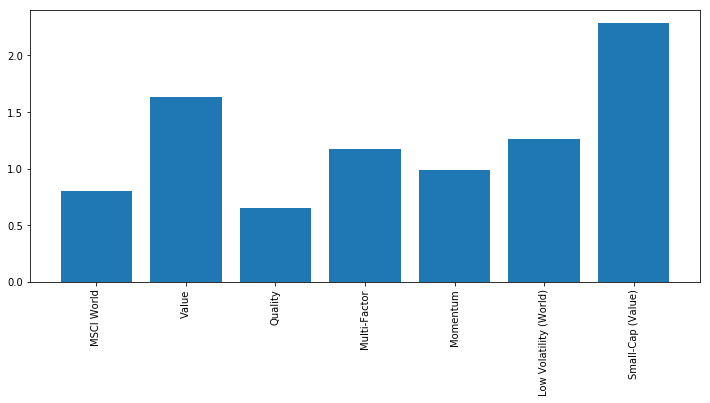

In [7]:
D={}
plt.figure(figsize=(12, 5))
for key in factors.keys():
    D[key] = factors[key].sum()
plt.bar(*zip(*D.items()))
plt.xticks(rotation = 90)
plt.show()

What we can see here is kind of telling. The Multi-Factor index is not outstanding! If the Mult-Factor index is clearly surperior we would have expected a high value here.
Let's look into the details and the individual factor for each of the 5 factors of the model:

C:\Users\MartinSchmitz\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


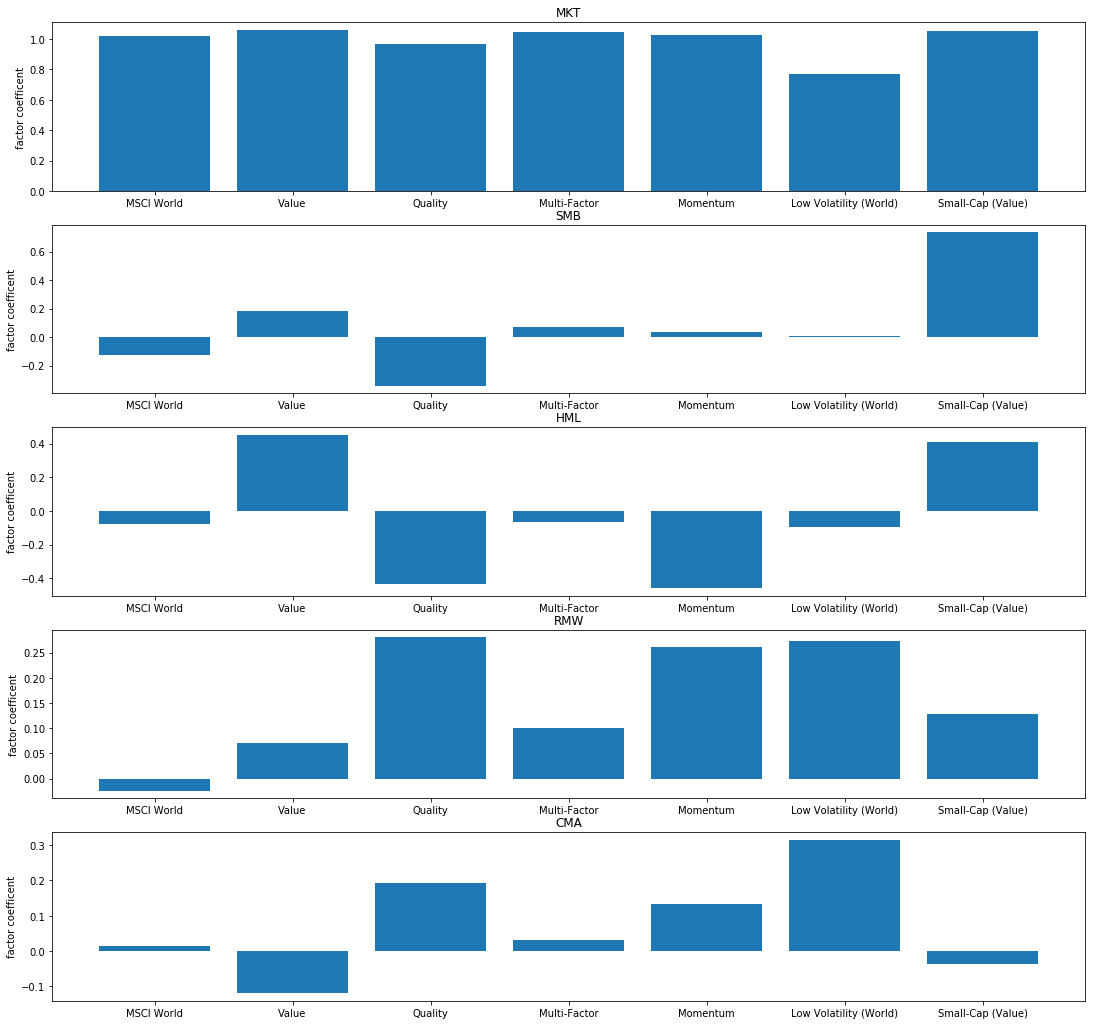

In [8]:
fig, axs = plt.subplots(5)
i = 0

for factorname in ["MKT","SMB","HML","RMW","CMA"]:
    D = {}
    for key in factors.keys():
        D[key] = factors[key][factorname]
    axs[i].bar(*zip(*D.items()))
    axs[i].set_title(factorname)
    #axs[i].set_ylim(-0.2,0.5)
    axs[i].set_ylabel("factor coefficent")
    i+=1
fig.set_size_inches(18.5, 18)
fig.show()

And for completness, lets look at it the other way around and see it grouped by the index:

C:\Users\MartinSchmitz\Anaconda3\lib\site-packages\matplotlib\tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
C:\Users\MartinSchmitz\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


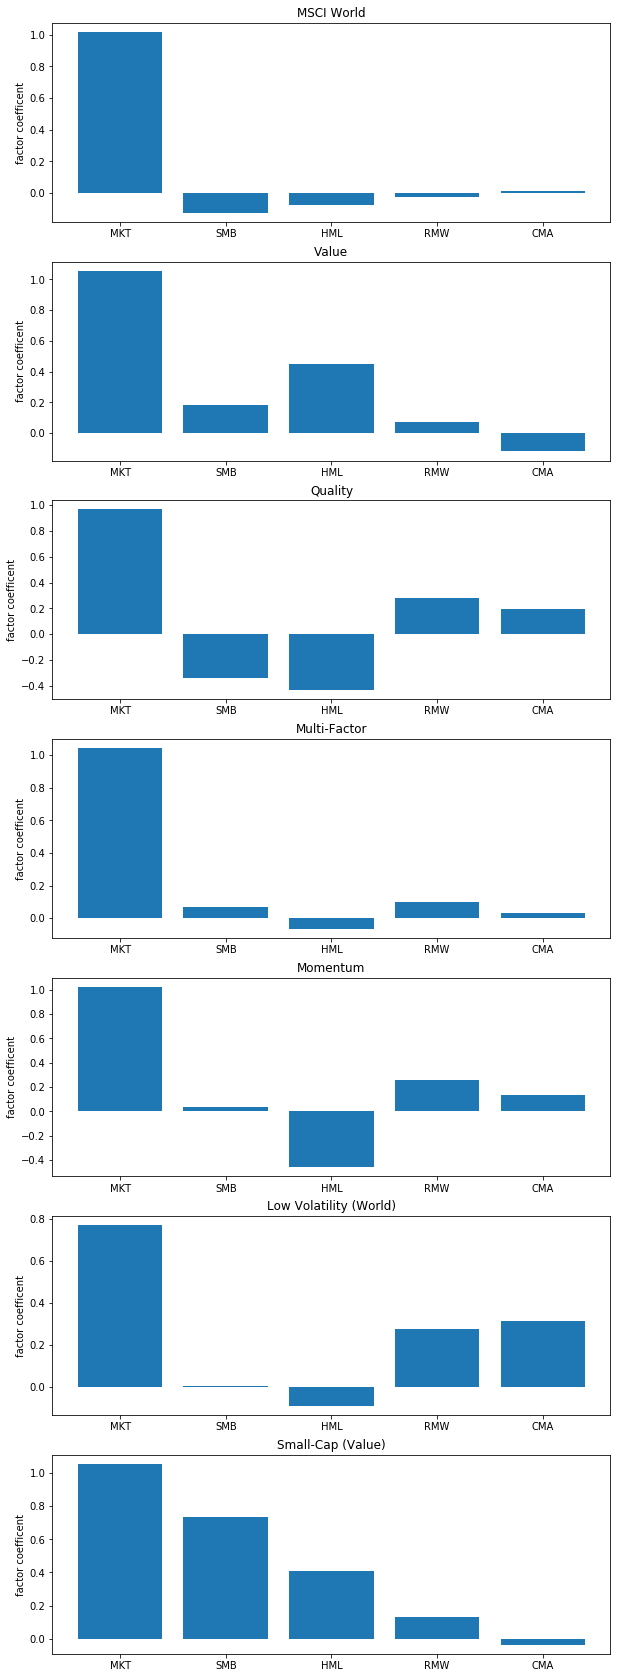

In [9]:
fig, ax = plt.subplots(len(index_codes))

width = 0.35  # the width of the bars
i = 0
for key in factors.keys():
    D = {}
    for factorname in ["MKT","SMB","HML","RMW","CMA"]:
        D[factorname] = factors[key][factorname]
        
    ax[i].bar(*zip(*D.items()),label=key)
    ax[i].set_title(key)
    #ax[i].set_ylim(-0.2,0.5)
    ax[i].set_ylabel("factor coefficent")
    i+=1
    


fig.tight_layout()
fig.set_size_inches(10, 30)
fig.show()

What can we learn from here? First: Small Cap (Value) seams to be a beast! It offers exposure to the market, SMB and HML! And it does not even have negative contributions to RMW and CMA. Wow! One needs to remind oneselve, that Small Cap (Value) only has a [single ETF](https://www.justetf.com/de-en/etf-profile.html?groupField=index&from=search&isin=IE00BSPLC413) in Germany which is relativly expensive (0.3% TER)

# Factor Exposure and Expected Returns for Mixtures

Lets move into the optimization. We first define our factor matrix

In [10]:
factor_matrix = pd.DataFrame.from_dict(factors).drop(["Intercept"],axis=0)

The factorness vector $\vec{f}$ can now be expressed as:
\begin{equation}
\vec{f} = \underline{F} \cdot \alpha
\end{equation}
Where $\underline{F}$ is the factor matrix and $\alpha$ our asset allocation vector.

**This boils down to the key open question: How to weight the different factors?** 

As an idea, lets take the average factor values from FF, scale them to a year and take them as a weightening factor. We can then just calculate the returns as:
\begin{equation}
    r = \vec{f} \cdot \vec{P}
\end{equation}
Where P holds the averages of the factors.

*Note: Maybe we want to take the monthly factor values here?*

*Note2: Just scaling it ignores the compound effect*

*Note3: The Small Cap Value is like a US ETF, so ideally one may want to use the higher US values here?*




In [11]:

index_names = df.columns.tolist()
index_names.remove("date")
numberOfIndecies = len(index_names)
def factorness(alpha):
  return factor_matrix.dot(alpha)

average_factors = get_average_factors("Developed")*252
def excess_returns(alpha):
    factors = factorness(alpha)
    returns = average_factors.dot(factors)
    return returns*100
asset_allocations = {} # this will hold all proposals for later loops etc

Lets now define a few portfolios which can be interesting for us

In [51]:
from asset_allocation import AssetAllocation

multi_factor_allocation = AssetAllocation(index_names)
multi_factor_allocation = multi_factor_allocation.set_allocation("Multi-Factor",1)
multi_factorness = factorness(multi_factor_allocation.to_array())
asset_allocations["Pure Multi"] = multi_factor_allocation

world_allocation = AssetAllocation(index_names)
world_allocation = world_allocation.set_allocation("MSCI World",1)
world_factorness = factorness(world_allocation.to_array())
asset_allocations["Pure World"] = world_allocation



small_value_momentum_allocation = AssetAllocation(index_names);
small_value_momentum_allocation.set_allocation("Small-Cap (Value)",0.4)
small_value_momentum_allocation.set_allocation("Momentum",0.2)
small_value_momentum_allocation.set_allocation("Value",0.4)

asset_allocations["Small-Value-Momentum"] = small_value_momentum_allocation

small_momentum_value_allocation = AssetAllocation(index_names);
small_momentum_value_allocation.set_allocation("Small-Cap (Value)",0.4)
small_momentum_value_allocation.set_allocation("Momentum",0.4)
small_momentum_value_allocation.set_allocation("Value",0.2)
asset_allocations["Small-Momentum-Value"] = small_momentum_value_allocation


small_quality_value_allocation = AssetAllocation(index_names);
small_quality_value_allocation.set_allocation("Small-Cap (Value)",0.4)
small_quality_value_allocation.set_allocation("Quality",0.2)
small_quality_value_allocation.set_allocation("Value",0.4)
small_quality_value_factorness = factorness(small_quality_value_allocation.to_array())
asset_allocations["Small-Quality-Value"] = small_quality_value_allocation

even_allocations = AssetAllocation(index_names)
even_allocations.set_allocation("Value",0.2)
even_allocations.set_allocation("Quality",0.2)
even_allocations.set_allocation("Momentum",0.2)
even_allocations.set_allocation("Low Volatility (World)",0.2)
even_allocations.set_allocation("Small-Cap (Value)",0.2)
asset_allocations["Even Allocation"] = even_allocations

In [13]:
result_dict = {}
#print(asset_allocations.keys())
for key in asset_allocations.keys():
    result_dict[key] = {}
    factorness_vector = factorness(asset_allocations[key].to_array())
    result_dict[key]["factorness"] = float(factorness_vector.sum())
    result_dict[key]["returns"] = float(excess_returns(asset_allocations[key].to_array())[0])
    for name, value in zip(["MKT","SMB","HML","RMW","CMA"],factorness_vector[0]):
        result_dict[key][name] = value

    
result_df = pd.DataFrame(result_dict).T.sort_values("returns",ascending=False)
display(result_df)

,CMA,HML,MKT,RMW,SMB,factorness,returns
Small-Value-Momentum,-0.035734,0.252751,1.049853,0.131801,0.373880,1.772550,7.349541
Small-Quality-Value,-0.023949,0.257902,1.038260,0.135663,0.297798,1.705673,7.300103
Small-Momentum-Value,0.014648,0.070525,1.043450,0.169957,0.345182,1.643762,7.190811
Even Allocation,0.096647,-0.025151,0.974873,0.202579,0.123205,1.372153,6.800995
Pure Multi,0.030803,-0.065442,1.043465,0.101056,0.070747,1.180629,6.550843
Pure World,0.013704,-0.077697,1.017816,-0.023954,-0.125962,0.803906,5.741138


# Numerical Optimization for Returns
We can now try to use a numerical optimization in order to find the result which maximizes the total factorness $\phi$. One key thing here is, that we need to specifiy bonds. If not the optimizer will throw everything into Small Cap (Value), since it's a beast.
Lets define bounds as \[0, 0.4\] and lets also deactivate the use of multi factor:

In [14]:

from scipy.optimize import minimize
# objective function
def func(alpha):
    return -1*excess_returns(alpha)

# constraint: sum(weights) = 1
fconst = lambda w: 1 - sum(w)
cons   = ({'type':'eq','fun':fconst})

# initial weights
w0 =  np.ones((len(index_codes),1))/len(index_codes)

# define bounds
b    = (0.0, 0.4) 
bnds = [b for i in range(0,numberOfIndecies)]
bnds[3] = (0.0,0.0001)
# minimize
sol_returns  = minimize(func,
                w0,
                bounds      = bnds,
                constraints = cons)
print(sol_returns.fun*-1)
return_optimize_dict = {}
for alloc, name in zip(sol_returns.x,factor_matrix.columns):
    return_optimize_dict[name]=alloc

display(pd.DataFrame.from_records(return_optimize_dict,index=["allocation"]).round(decimals=2))
asset_allocations["Return Optimized"] = AssetAllocation(index_names).set_allocations(sol_returns.x)


7.349546129056886


,Low Volatility (World),MSCI World,Momentum,Multi-Factor,Quality,Small-Cap (Value),Value
allocation,0.0,0.0,0.2,0.0,0.0,0.4,0.4



It is somewhat funny to see, that the result of this longer analys
is is a bit the trivial solution of taking the 3 best running ones and mixing them. The reason for this is that we do not yet consider volatility nor diversification as a constraint for our optimization.


,Even Allocation,Pure Multi,Pure World,Return Optimized,Small-Momentum-Value,Small-Quality-Value,Small-Value-Momentum
returns,1.059857,0.809705,0.0,1.608408,1.449673,1.558965,1.608403


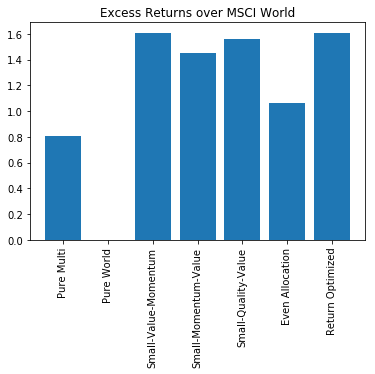

In [15]:
return_dict = {}
for key, value in asset_allocations.items():
    return_dict[key] = float(excess_returns(value.to_array()).iloc[0])
# normalize to MSCI World returns
pure_world_return = return_dict["Pure World"]
for key, value in return_dict.items():
    return_dict[key] = value-pure_world_return
    
display(pd.DataFrame.from_records(return_dict,index=["returns"]))
plt.bar(return_dict.keys(), return_dict.values())
plt.title("Excess Returns over MSCI World")
plt.xticks(rotation = 90)
plt.show()

In [16]:
from factor_estimator import create_index_of_indices
for key, value in asset_allocations.items():
    df = create_index_of_indices(df,key,value)


<Figure size 1440x864 with 0 Axes>

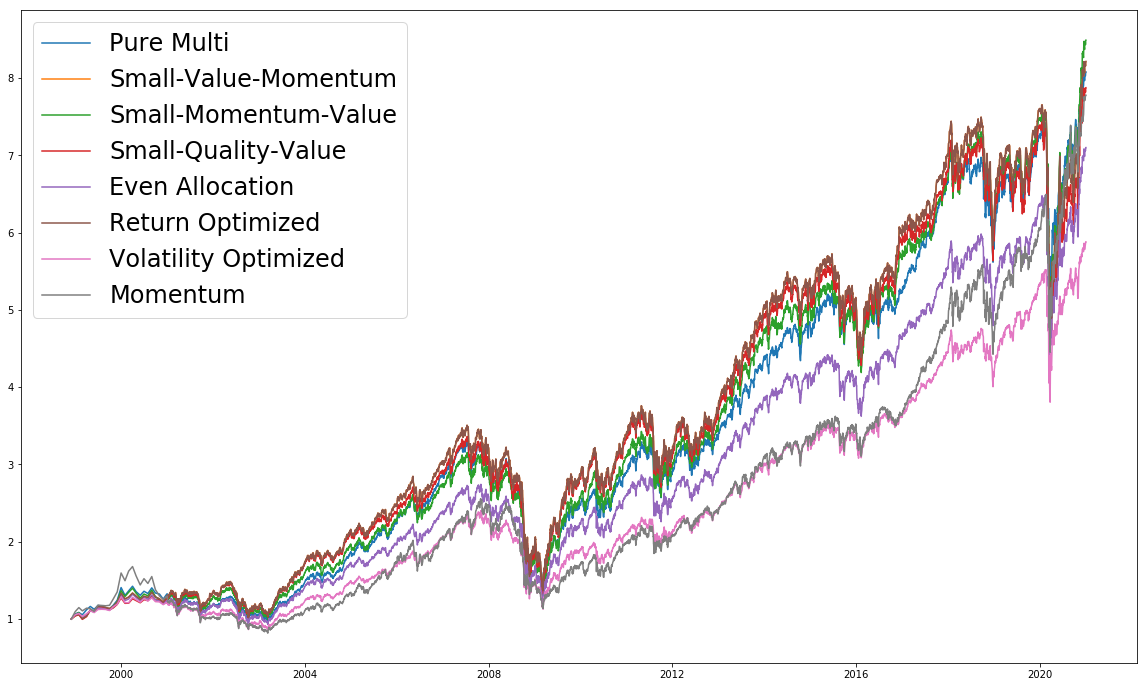

In [78]:
plt.figure(figsize=(20, 12))
allocs_to_show = [key for key in asset_allocations.keys()]
allocs_to_show.remove("Pure World")
allocs_to_show.append("Momentum")
plt.figure(figsize=(20, 12))

for k in allocs_to_show:
    plt.plot(df["date"],df[k], label=k)
#gfg = sns.lineplot(data = df[c])
plt.legend(prop={'size':24})
plt.show()


# Taking Volatility into Account

In [18]:
volatility_dict = {}
for key in asset_allocations.keys():
    volatility_dict[key] = df[key].pct_change().dropna().std()*100
display(pd.DataFrame.from_records(volatility_dict,index=["daily standard deviation"]))

,Even Allocation,Pure Multi,Pure World,Return Optimized,Small-Momentum-Value,Small-Quality-Value,Small-Value-Momentum
daily standard deviation,1.075254,1.07138,1.067769,1.208806,1.218894,1.216525,1.208807


In [69]:
from scipy.optimize import minimize
# objective function
regularizationFactor = 1
volatility_chart_dict = {}
def volatility(alpha):
    alloc = AssetAllocation(index_names)
    alloc.set_allocations(alpha)
    aux = create_index_of_indices(df,"aux",alloc)
    std_dev = df["aux"].pct_change().dropna().std()*100
    return std_dev

def func(alpha):
    return -1*excess_returns(alpha).sum()+regularizationFactor*volatility(alpha)
results = {}
for regularizationFactor in range(0,15):
    


    # constraint: sum(weights) = 1
    fconst = lambda w: 1 - sum(w)
    cons   = ({'type':'eq','fun':fconst})

    # initial weights
    w0 =  np.ones((len(index_codes),1))/len(index_codes)

    # define bounds
    b    = (0.0, .4) 
    bnds = [b for i in range(0,numberOfIndecies)]
    bnds[3] = (0.0,0.0001)
    # minimize
    sol  = minimize(func,
                    w0,
                    bounds      = bnds,
                    constraints = cons)

    optimized_allocation = AssetAllocation(index_names)
    optimized_allocation = optimized_allocation.set_allocations(sol.x)
#     print("### "+str(regularizationFactor)+" ###")
#     print(excess_returns(sol.x).sum(),"  /  ",volatility(sol.x))
#     print(optimized_allocation)
    results[regularizationFactor] = optimized_allocation.allocations
    results[regularizationFactor]["Returns"] = excess_returns(sol.x).sum()
    results[regularizationFactor]["Volatility"] = volatility(sol.x)

fit_results = pd.DataFrame.from_dict(results)
for c in fit_results.columns:
    fit_results[c] = fit_results[c].round(decimals=2)
display(fit_results)
comparison_dict = {"Pure World":{},"Pure Multi":{}}
comparison_dict["Pure World"]["Returns"] = float(excess_returns(asset_allocations["Pure World"].to_array()).sum())
comparison_dict["Pure World"]["Volatility"] = float(volatility(asset_allocations["Pure World"].to_array()))
comparison_dict["Pure Multi"]["Returns"] = float(excess_returns(asset_allocations["Pure Multi"].to_array()).sum())
comparison_dict["Pure Multi"]["Volatility"] = float(volatility(asset_allocations["Pure Multi"].to_array()))
comparison_df = pd.DataFrame.from_dict(comparison_dict)
display(comparison_df)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Low Volatility (World),0.00,0.00,0.00,0.40,0.40,0.40,0.40,0.40,0.40,0.40,0.40,0.40,0.40,0.40,0.40
MSCI World,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Momentum,0.20,0.20,0.20,0.07,0.17,0.20,0.20,0.18,0.14,0.12,0.10,0.09,0.09,0.08,0.09
Multi-Factor,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Quality,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.17,0.26,0.31,0.35,0.38,0.40,0.40
Returns,7.35,7.35,7.35,6.84,6.71,6.67,6.67,6.66,6.54,6.47,6.42,6.38,6.36,6.34,6.34
Small-Cap (Value),0.40,0.40,0.40,0.13,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Value,0.40,0.40,0.40,0.40,0.40,0.40,0.40,0.40,0.29,0.23,0.18,0.15,0.13,0.12,0.11
Volatility,1.21,1.21,1.21,1.01,0.97,0.96,0.96,0.96,0.94,0.94,0.93,0.93,0.93,0.92,0.92


,Pure World,Pure Multi
Returns,5.741138,6.550843
Volatility,1.067769,1.071380


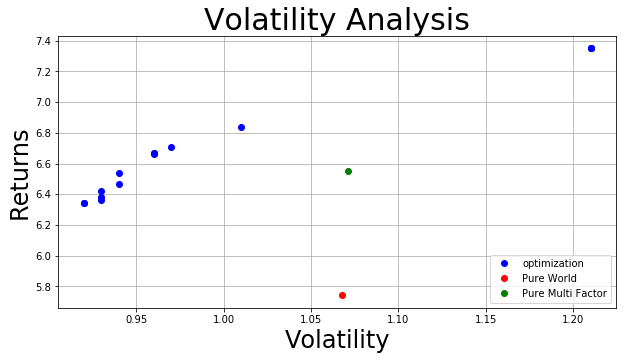

In [74]:
plot_df = fit_results.T[["Returns","Volatility"]]
plt.figure(figsize=(10, 5))
plt.title("Volatility Analysis",fontsize=30)
plt.xlabel("Volatility",fontsize=24)
plt.ylabel("Returns",fontsize=24)
plt.grid(True)

plt.plot(plot_df["Volatility"], plot_df["Returns"],'bo',label="optimization")
plt.plot(comparison_df.T["Volatility"][0], comparison_df.T["Returns"][0],'ro',label="Pure World")
plt.plot(comparison_df.T["Volatility"][1], comparison_df.T["Returns"][1],'go',label="Pure Multi Factor")
plt.legend(loc="lower right")

What can we learn from here? Well, we have a few interesting portfolios i think:

## The High Risk High Return Portfolio:
Thats the top right. It is
* 40% Small Cap (Value)
* 40% Value
* 20% Momentum
This gives you roughly 7.35% returns or 1.6% gain over the MSCI World. You pay for it with higher Volatility. 

## The Low Volatility
Thats on the lower left (there are a few, thats the "10")::
* 33% Low Volatility
* 10% Momentum
* 32% Quality
* 18% Value

You can get a roughly 6.5% return (remember, this is compared to US Treasury bonds). Which is 0.7% gain over the MSCI World or roughly the same as the Multi-Factor. 

In [75]:
# Add the volatility optimized allocation to our main data frame
volatility_allocation = AssetAllocation(index_names)
for name, alloc in results[10].items():
    if(name is not "Returns" and name is not "Volatility"):
        volatility_allocation.set_allocation(name, alloc)

asset_allocations["Volatility Optimized"] = volatility_allocation
df = create_index_of_indices(df,"Volatility Optimized",volatility_allocation)

<Figure size 1440x864 with 0 Axes>

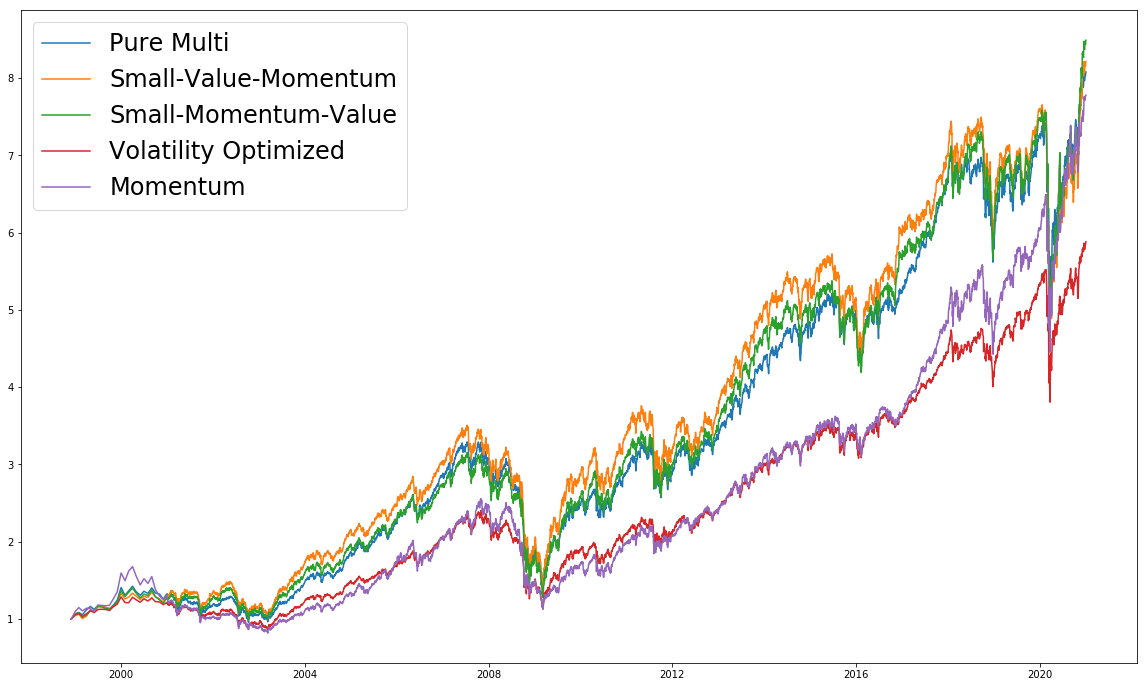

In [77]:
plt.figure(figsize=(20, 12))
allocs_to_show = [key for key in asset_allocations.keys()]
allocs_to_show.remove("Pure World")
allocs_to_show.remove("Even Allocation")
allocs_to_show.remove("Small-Quality-Value")
allocs_to_show.remove("Return Optimized")
allocs_to_show.append("Momentum")


plt.figure(figsize=(20, 12))

for k in allocs_to_show:
    plt.plot(df['date'],df[k],label=k)
#gfg = sns.lineplot(data = df[c])
plt.legend(prop={'size':24})
plt.show()


## A first conclusion


# The Momentum Value Trade Off

# Holding Analysis